# Illustris TNG
The purpose of this notebook is to connect to the Illustris project and download the data for galaxy clusters in the mass range:
$$10^{13.75}M_{\odot}<M_{500}<10^{15.06}M_{\odot}$$
at z=0 in the Friends-of-Friends group. Then, we will simulate Chandra observations of the clutsers.

In [1]:
%matplotlib inline
from additionalfunctions import utherm_ne_to_temp, solar_met, update_progress
import requests
import pickle
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yt
from yt.utilities.cosmology import Cosmology
import pyxsim
import os
import shutil
import soxs

soxs : [WARNING  ] 2021-11-09 15:38:13,474 Setting 'soxs_data_dir' to /home/carterrhea/.cache/soxs for this session. Please update your configuration if you want it somewhere else.


## Step 1: Download subhalos from Illustris TNG 
If you have already downloaded the subhalos, you can skip this step and move directly to step 2!

In [2]:
output_dir = 'TNG300/Clusters'  # Directory where the cluster ICM information will be stored
snapshot_id = 99  # ID of snapshot

# Make sure the output directory exists. If not, create it
if not os.path.exists('%s/snapshot_%i/'%(output_dir, snapshot_id)):
    os.mkdir('%s/snapshot_%i/'%(output_dir, snapshot_id))

In [3]:
#Basic setup taken from Illustris TNG wiki with my personal api-key

baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"df26a8d0d3e4ec231734b077b81291cb"}

def get(path, params=None, output_dir_cutout='Clusters'):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(output_dir_cutout+'/'+filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r
r = get(baseUrl)

In [4]:
# first convert log solar masses into group catalog units
mass_min = 10**13.75 / 1e10 * 0.704
mass_max = 10**15.06 / 1e10 * 0.704
print(mass_min,mass_max)
# form the search_query string by hand for once
search_query = "?mass__gt=" + str(mass_min) + "&mass__lt=" + str(mass_max)


3958.8829293400577 80830.01495338063


How many clusters (subhalos) are within this range in the z=0 snapshot of TNG 300?

In [5]:
url = "http://www.tng-project.org/api/TNG300-1/snapshots/z=0/subhalos/" + search_query
subhalos = get(url)
ids = [subhalos['results'][i]['id'] for i in range(len(subhalos['results'])) ]
num_subhalos = 1#subhalos['count']
print("There are %i clusters in the z=0 snapshot of TNG 300."%num_subhalos)
# Now let's save this list in a txt file
with open('snapshot%i_clusters.txt'%snapshot_id, 'w+') as f_out:
    f_out.write('# List of subhalo IDS corresponding to clusters with log masses between 13.75 and 15.06\n')
    for id_ in ids:
        f_out.write('%i\n'%id_)

There are 1 clusters in the z=0 snapshot of TNG 300.


Let's take a quick lok at what these look like. You will see that it has the subhalo ID, the SFR, the log of the mass, and the URL to the subhalo.

In [6]:
subhalos['results'][:2]

[{'id': 1,
  'sfr': 0.0,
  'mass_log_msun': 14.729459652476862,
  'url': 'http://www.tng-project.org/api/TNG300-1/snapshots/99/subhalos/1/'},
 {'id': 17908,
  'sfr': 6.94472,
  'mass_log_msun': 15.042908906181673,
  'url': 'http://www.tng-project.org/api/TNG300-1/snapshots/99/subhalos/17908/'}]

Now that we have our list of subhalos, we can go ahead and loop through each and save their cutouts. We don't need to save all of their information though! Instead we just need the parameters relevant to the X-ray emission

In [7]:
base_url = "http://www.tng-project.org/api/TNG300-1/"
sim_metadata = get(base_url)
#num_subhalos = 2
update_progress(0)
for id_ in ids[:num_subhalos]:
    snapshot_url = "http://www.tng-project.org/api/TNG300-1/snapshots/z=0/subhalos/" + str(id_) + "/cutout.hdf5"
    saved_filename = get(snapshot_url, params={"gas":"all"}, output_dir_cutout='%s/snapshot_%i/'%(output_dir, snapshot_id))
    update_progress(id_ / num_subhalos)


Progress: [####################] 100.0%


### Quick Detour: Visualization
Let's visualize how one of these clutsers look

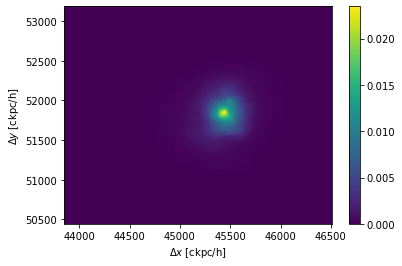

In [8]:
with h5py.File('cutout_1.hdf5','r') as f:
    x = f['PartType0']['Coordinates'][:,0]
    y = f['PartType0']['Coordinates'][:,1]
    dens = f['PartType0']['Density'][:]

plt.hist2d(x,y,weights=dens,bins=[300,300])
plt.xlabel('$\Delta x$ [ckpc/h]')
plt.ylabel('$\Delta y$ [ckpc/h]')

plt.colorbar()

What are all the parameters that we have in the file?

In [9]:
with h5py.File('cutout_1.hdf5','r') as f:
    for name in f['PartType0']:
        print(name)

CenterOfMass
Coordinates
Density
ElectronAbundance
EnergyDissipation
GFM_AGNRadiation
GFM_CoolingRate
GFM_Metallicity
GFM_Metals
GFM_MetalsTagged
GFM_WindDMVelDisp
GFM_WindHostHaloMass
InternalEnergy
Machnumber
MagneticField
MagneticFieldDivergence
Masses
NeutralHydrogenAbundance
ParticleIDs
Potential
StarFormationRate
SubfindDMDensity
SubfindDensity
SubfindHsml
SubfindVelDisp
Velocities


While these are all very interesting properties, we do need need all of these! Let's go ahead and make some pickle files containing the information that we  need for each cluster!

In [10]:
'''ct = 0
update_progress(0)
for id_ in ids[:num_subhalos]:  # Step through all clusters
    # Get the values we want
    with h5py.File('%s/snapshot_%i/cutout_%i.hdf5'%(output_dir,snapshot_id,id_),'r') as f:
        gas = f['PartType0']
        x = gas['Coordinates'][:,0]
        y = gas['Coordinates'][:,1]
        z = gas['Coordinates'][:,2]
        velx = gas['Velocities'][:,0]
        vely = gas['Velocities'][:,1]
        velz = gas['Velocities'][:,2]
        particle_mass = gas['Masses'][:]
        metallicity = solar_met(gas['GFM_Metallicity'][:])
        density = gas['Density'][:]
        density_sq = gas['Density'][:].T*gas['Density'][:]
        temp = utherm_ne_to_temp(gas['InternalEnergy'][:],gas['ElectronAbundance'][:])
        ElectronAbundance = gas['ElectronAbundance'][:]
        NeutralHydrogenAbundance = gas['NeutralHydrogenAbundance'][:]
        # Put in appropriate YT form
        cluster = {"x":x, "y":y, "z":z,
            'particle_position_x': (x, "kpc"),
            'particle_position_y': (y, "kpc"),
            'particle_position_z': (z, "kpc"),
            'particle_velocity_x': (velx*10000.0, "cm/s"),
            'particle_velocity_y': (vely*10000.0, "cm/s"),
            'particle_velocity_z': (velz*10000.0, "cm/s"),
            'density_sq' : density_sq,
            'temperature': temp,
            'metallicity': metallicity,
            'particle_mass': particle_mass,
            'density': density,
            'ElectronAbundance': ElectronAbundance,
            'NeutralHydrogenAbundance': NeutralHydrogenAbundance}
        # Assign to cluster dictionary
        #cluster = {"x":x, "y":y, "z":z, "mass":particle_mass, "metallicity":metallicity, "density":density, "density_sq":density_sq,
                   #"temp":temp, "ElectronAbundance":ElectronAbundance, "NeutralHydrogenAbundance":NeutralHydrogenAbundance,
                   #"velx":velx, "vely":vely, "velz":velz}
        # Save to pickle file
        pickle.dump(cluster, open('%s/snapshot_%i/cluster_%i.pkl'%(output_dir,snapshot_id, id_), 'wb'))
        update_progress(id_ / num_subhalos)
'''

'ct = 0\nupdate_progress(0)\nfor id_ in ids[:num_subhalos]:  # Step through all clusters\n    # Get the values we want\n    with h5py.File(\'%s/snapshot_%i/cutout_%i.hdf5\'%(output_dir,snapshot_id,id_),\'r\') as f:\n        gas = f[\'PartType0\']\n        x = gas[\'Coordinates\'][:,0]\n        y = gas[\'Coordinates\'][:,1]\n        z = gas[\'Coordinates\'][:,2]\n        velx = gas[\'Velocities\'][:,0]\n        vely = gas[\'Velocities\'][:,1]\n        velz = gas[\'Velocities\'][:,2]\n        particle_mass = gas[\'Masses\'][:]\n        metallicity = solar_met(gas[\'GFM_Metallicity\'][:])\n        density = gas[\'Density\'][:]\n        density_sq = gas[\'Density\'][:].T*gas[\'Density\'][:]\n        temp = utherm_ne_to_temp(gas[\'InternalEnergy\'][:],gas[\'ElectronAbundance\'][:])\n        ElectronAbundance = gas[\'ElectronAbundance\'][:]\n        NeutralHydrogenAbundance = gas[\'NeutralHydrogenAbundance\'][:]\n        # Put in appropriate YT form\n        cluster = {"x":x, "y":y, "z":z,\n

## Step 2: Create photon event files
In this step we will use pyxsim to create photon event files from our clusters


In [11]:
def hot_gas(pfilter, data):
    pfilter1 = data[pfilter.filtered_type, "density"] < 5e-25
    pfilter2 = data[pfilter.filtered_type, "temperature"] > 3481355.78432401
    pfilter3 = data[pfilter.filtered_type, "temperature"] < 4.5e8
    return ((pfilter1) & (pfilter2) & (pfilter3))

In [15]:
if not os.getcwd().endswith(str(snapshot_id)):
    os.chdir("%s/%s/snapshot_%i"%(os.getcwd(), output_dir,snapshot_id))
#time_unit = yt.YTQuantity(1.0e-5, "kpc*s/cm").to("s")
#velocity_unit = yt.YTQuantity(1.0e5, "cm/s")
#update_progress(0)
for id_ in ids[:1]:  # Step through all clusters
    ds = yt.load('cutout_%i.hdf5'%id_, default_species_fields='ionized')
     
    sp = ds.sphere("max", (3.0, "Mpc"))

    redshift = 0.04 # The redshift to the object.
    area = (1000., "cm**2") # A constant effective area to generate the photons with.
    exp_time = (100., "ks") # The exposure time to generate the photons with.
    # Optionally, construct a cosmology object.
    cosmo = Cosmology(hubble_constant=0.68, omega_matter=0.31, omega_lambda=0.69)
    #Set source thermal model
    source_model = pyxsim.ThermalSourceModel("apec", 0.05, 11.0, 1000, kT_scale='log',
                                              Zmet=('gas','metallicity'),
                                              emission_measure_field=('gas','emission_measure'),
                                              temperature_field=('gas','temperature'))
    #Create photon list
    n_photons, n_cells = pyxsim.make_photons("cluster_photons_%i"%id_, sp, redshift, area, exp_time, source_model, cosmology=cosmo)
    n_events = pyxsim.project_photons("cluster_photons_%i"%id_, "cluster_events_%i"%id_, "x", (45., 30.), absorb_model="tbabs", nH=0.04)
    # Write out 
    events = pyxsim.EventList("cluster_events_%i.h5"%id_)
    events.write_to_simput("cluster_%i"%id_, overwrite=True)
    #update_progress(id_ / num_subhalos)

yt : [INFO     ] 2021-11-09 15:51:20,416 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2021-11-09 15:51:20,606 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2021-11-09 15:51:20,607 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-11-09 15:51:20,609 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-11-09 15:51:20,610 Parameters: domain_right_edge         = [205000. 205000. 205000.]
yt : [INFO     ] 2021-11-09 15:51:20,611 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-11-09 15:51:20,613 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2021-11-09 15:51:20,614 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2021-11-09 15:51:20,615 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2021-11-09 15:51:20,616 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-11-09 15:51:20,618 Parameters: hubble_con

Preparing spectrum table :   0%|          | 0/201 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/6308389 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2021-11-09 15:58:00,239 Finished generating photons.
pyxsim : [INFO     ] 2021-11-09 15:58:00,240 Number of photons generated: 40901515
pyxsim : [INFO     ] 2021-11-09 15:58:00,242 Number of cells with photons: 5652050
pyxsim : [INFO     ] 2021-11-09 15:58:00,245 Foreground galactic absorption: using the tbabs model and nH = 0.04.
Projecting photons from cells/particles: 100%|██████████████████████████████████████████| 5652050/5652050 [07:34<00:00, 12426.03it/s]
pyxsim : [INFO     ] 2021-11-09 16:05:35,294 Detected 14431263 events.
soxs : [WARNING  ] 2021-11-09 16:05:36,178 Overwriting cluster_1_phlist.fits.
soxs : [INFO     ] 2021-11-09 16:05:36,700 Writing source to cluster_1_phlist.fits.


## Step 3:
Now that we have our photons corresponding to each cluster, we can convolve them through our favorite instrumental response

Progress: [####################] 100.0%


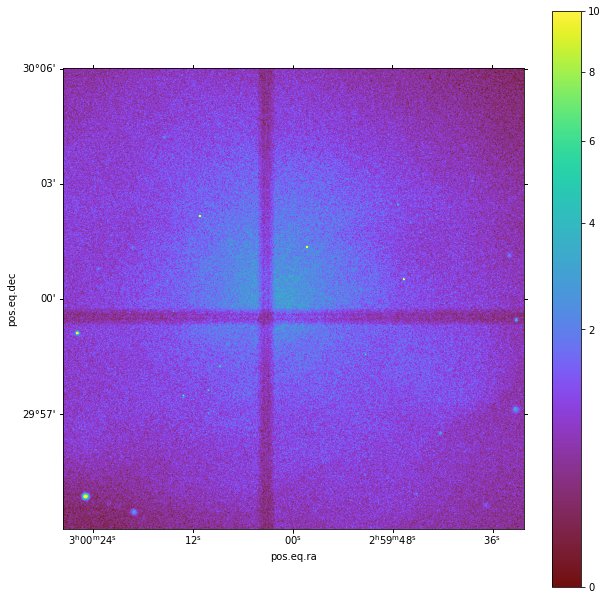

In [16]:
update_progress(0)
for id_ in ids[:1]:  # Step through all clusters
    soxs.instrument_simulator("cluster_%i_simput.fits"%id_, "cluster_%i_evt.fits"%id_, (200.0, "ks"), "chandra_acisi_cy0",
                          [45., 30.], overwrite=True, instr_bkgnd=True, foreground=True, ptsrc_bkgnd=True)
    # Turn event file into image
    soxs.write_image("cluster_%i_evt.fits"%id_, "cluster_%i_img.fits"%id_, emin=0.5, emax=2.0, overwrite=True)
    # Plot out 
    soxs.plot_image("cluster_%i_img.fits"%id_, stretch='sqrt', cmap='arbre', vmin=0.0, vmax=10.0, width=0.2)
    update_progress(id_ / num_subhalos)
